In [ ]:
!python -m pip install transformers datasets huggingface_hub -q
!git clone https://github.com/h4rr9/ttim.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 8.2 MB/s eta 0:00:00
Cloning into 'ttim'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remo

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset
from ttim.model import Tim as Tim
from transformers import AutoTokenizer
import torch
from tqdm.auto import tqdm

# 1 bit

In [ ]:
d1 = load_dataset('h4rr9/mnist_palette_num_1_bit')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/h4rr9___parquet/h4rr9--mnist_palette_num_1_bit-519e648845331b23/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
m1 = Tim.from_pretrained('h4rr9/mnist_1bit_new').to('cuda')
t1 = AutoTokenizer.from_pretrained('h4rr9/mnist_1bit_new')

In [ ]:
prompt = '[ImageFirst]' + d1['validation']['palette_images'][0] + '[Text]'
caption = d1['validation']['captions'][0]

In [ ]:
inputs = t1(prompt, return_tensors='pt')
input_ids = inputs['input_ids'].to('cuda')
attention_mask = inputs['attention_mask'].to('cuda')
image_masks = torch.zeros_like(input_ids, dtype=torch.bool)
image_masks[0, 2:1026] = True

In [ ]:
img_str = t1.decode(input_ids[image_masks])

len([img_str[chunk_idx: chunk_idx + 3].strip('][') for chunk_idx in range(0, len(img_str), 3)])

1024

In [ ]:
inputs_embeds = m1.prepare_inputs(input_ids=input_ids, image_masks=image_masks)

In [ ]:
[output] = m1.generate(inputs_embeds=inputs_embeds, attention_mask=attention_mask, max_new_tokens=1)

In [ ]:
t1.decode(output, skip_special_tokens=True), caption

('7', '7')

In [ ]:
# create prompt
res = []

image_masks = torch.zeros_like(input_ids, dtype=torch.bool)
image_masks[0, 2:1026] = True

m1.eval()

for idx in tqdm(range(10000)):
  prompt = '[ImageFirst]' + d1['validation']['palette_images'][idx] + '[Text]'
  caption = d1['validation']['captions'][idx]

  # create inputs
  inputs = t1(prompt, return_tensors='pt')
  input_ids = inputs['input_ids'].to('cuda')
  attention_mask = inputs['attention_mask'].to('cuda')


  #prepare embeds
  inputs_embeds = m1.prepare_inputs(input_ids=input_ids, image_masks=image_masks)
  [output] = m1.generate(inputs_embeds=inputs_embeds, attention_mask=attention_mask, max_new_tokens=1)
  o = t1.decode(output, skip_special_tokens=True)

  if o == caption:
    res.append(1)
  else:
    res.append(0)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
print(sum(res) / len(res))

0.9904


In [ ]:
res_per_class = {i:0 for i in range(10)}
count_per_class = {i:0 for i in range(10)}

captions = d1['validation']['captions']
for (r, c) in tqdm(zip(res, captions)):
  res_per_class[int(c)] += r
  count_per_class[int(c)] += 1

res_per_class_acc = {k : res_per_class[k] / count_per_class[k] for k in res_per_class.keys()}

0it [00:00, ?it/s]

In [ ]:
res_per_class_acc

{0: 0.9959183673469387,
 1: 0.9973568281938326,
 2: 0.9912790697674418,
 3: 0.997029702970297,
 4: 0.994908350305499,
 5: 0.9831838565022422,
 6: 0.9926931106471816,
 7: 0.9902723735408561,
 8: 0.9907597535934292,
 9: 0.9692765113974232}

## HALF IMAGE GENERATION

In [ ]:
idx = -4
# idx = -7 # 0
# idx = -6 # 1
# idx = -5 # 2
# idx = -4 # 3
# idx = -3 # 4
# idx = -2 # 5
# idx = -1 # 6
# idx = 0 # 7
# idx = 6070 # 8
# idx = 1000 # 9

half_img = d1['validation']['palette_images'][idx]
caption = d1['validation']['captions'][idx]
half_img_len = len(half_img)//2
half_img = half_img[:half_img_len]
half_img = [half_img[chunk_idx: chunk_idx + 3] for chunk_idx in range(0, len(half_img), 3)]
half_pixel_tokens = [int(p.strip('][')) for p in half_img]
print(caption)

3


In [ ]:
m1.eval()
caption = '7'

prompt = ['[TextFirst]' , caption + '[Image]'] + half_img
pixels = list=(half_pixel_tokens)

inputs = t1(''.join(prompt), return_tensors='pt')
input_ids = inputs['input_ids'].to('cuda')

embeddings = m1.get_input_embeddings()

inputs_embeds = embeddings(input_ids)

positional_embeds = m1.pe


for i in range(512):
  inputs_embeds[:, i + 4, :] += positional_embeds[i]

for i in tqdm(range(512, 1024)):
  # generate 1 pixel

  [pixel_output] = m1.generate(inputs_embeds=inputs_embeds, max_new_tokens=1)
  pixel_id = int(t1.decode(pixel_output)[4:].strip('][')) # grab pixel id from text, ignore EOS token
  pixels.append(pixel_id)

  # append pixel embed
  pixel_token_id = 50265 + pixel_id # embedding lookup
  pixel_embed = embeddings(torch.tensor([[pixel_token_id]], dtype=torch.long, device='cuda'))
  pixel_embed_pos = pixel_embed[..., :] + positional_embeds[i, :] # add positional embeddings
  inputs_embeds = torch.concatenate([inputs_embeds, pixel_embed_pos], dim=1)



  0%|          | 0/512 [00:00<?, ?it/s]

In [ ]:
len(pixels), sum(pixels)

(1536, 269)

In [ ]:
import numpy as np
from PIL import Image

palette1 = np.load('./ttim/assets/1-bit.npy')

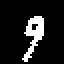

In [ ]:
Image.fromarray(palette1[pixels].reshape(32,32,3), 'RGB').resize((64, 64), Image.NEAREST).show()

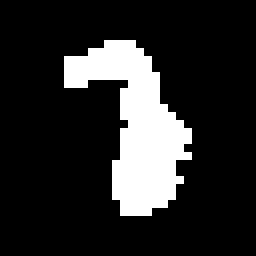

In [ ]:
Image.fromarray(palette1[pixels].reshape(32,32,3), 'RGB').resize((256, 256), Image.NEAREST).show()

## IMAGE GENERATION

* 1 with (272, 144) (checked)
* 2 with 264 (checked)
* 3 with 264 (checked)
* 4 with 272 (checked)
* 5 with 272 (checked)
* 6 with (256 + 8/16) (checked) struggles with loop, (128 + 8/16) incomplete 4 sign
* 7 with 264 (checked)
* 8 with (256 + 8/16, 128 + 8/16) (checked) struggles with loop
* 9 with (256 + 8/16) (checked) can make out 9 but no loop, (128 + 8/16) incomplete 4 sign
* 0 with (256 + 8/16, 128 + 8/16) struggles with loop

In [ ]:
m1.eval()

prompt = ['[TextFirst]' , '0' , '[Image]']
pixels = []

inputs = t1(''.join(prompt), return_tensors='pt')
input_ids = inputs['input_ids'].to('cuda')

embeddings = m1.get_input_embeddings()

inputs_embeds = embeddings(input_ids)

positional_embeds = m1.pe

for i in tqdm(range(1024)):
  # generate 1 pixel

  [pixel_output] = m1.generate(inputs_embeds=inputs_embeds, max_new_tokens=1)
  pixel_id = int(t1.decode(pixel_output)[4:].strip('][')) # grab pixel id from text, ignore EOS token

  if i == (256 + 16):
    pixel_id = 1

  pixels.append(pixel_id)

  # append pixel embed
  pixel_token_id = 50265 + pixel_id # embedding lookup
  pixel_embed = embeddings(torch.tensor([[pixel_token_id]], dtype=torch.long, device='cuda'))
  pixel_embed_pos = pixel_embed[..., :] + positional_embeds[i, :] # add positional embeddings
  inputs_embeds = torch.concatenate([inputs_embeds, pixel_embed_pos], dim=1)



  0%|          | 0/1024 [00:00<?, ?it/s]

In [ ]:
len(pixels), sum(pixels)

(1024, 268)

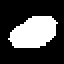

In [ ]:
Image.fromarray(palette1[pixels].reshape(32,32,3), 'RGB').resize((64, 64), Image.NEAREST).show()

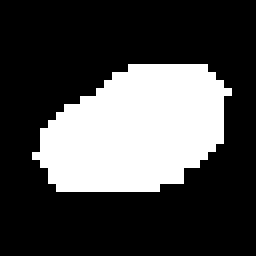

In [ ]:
Image.fromarray(palette1[pixels].reshape(32,32,3), 'RGB').resize((256, 256), Image.NEAREST).show()

# 9bit

In [ ]:
d9 = load_dataset('h4rr9/mnist_palette_num_9_bit')

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
m9 = Tim.from_pretrained('h4rr9/mnist_9bit_new').to('cuda')
t9 = AutoTokenizer.from_pretrained('h4rr9/mnist_9bit_new')

In [ ]:
prompt = '[ImageFirst]' + d9['validation']['palette_images'][-1] + '[Text]'
caption = d9['validation']['captions'][-1]

In [ ]:
inputs = t9(prompt, return_tensors='pt')
input_ids = inputs['input_ids'].to('cuda')
attention_mask = inputs['attention_mask'].to('cuda')
image_masks = torch.zeros_like(input_ids, dtype=torch.bool)
image_masks[0, 2:1026] = True

In [ ]:
img_str = t9.decode(input_ids[image_masks])
img_str

'[000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][219][365][292][146][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][146][292][438][511][511][365][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][073][146][292][438][511][511][511][438][219][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][073][146][292][438][511][511][511][511][365][146][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000][000

In [ ]:
len([img_str[chunk_idx: chunk_idx + 5].strip('][') for chunk_idx in range(0, len(img_str), 5)])

1024

In [ ]:
inputs_embeds = m9.prepare_inputs(input_ids=input_ids, image_masks=image_masks)

In [ ]:
[output] = m9.generate(inputs_embeds=inputs_embeds, attention_mask=attention_mask, max_new_tokens=1)

In [ ]:
t9.decode(output, skip_special_tokens=True), caption

('6', '6')

In [ ]:
from tqdm.auto import tqdm

# create prompt
res = []

image_masks = torch.zeros_like(input_ids, dtype=torch.bool)
image_masks[0, 2:1026] = True

m9.eval()

for idx in tqdm(range(10000)):
  prompt = '[ImageFirst]' + d9['validation']['palette_images'][idx] + '[Text]'
  caption = d9['validation']['captions'][idx]

  # create inputs
  inputs = t9(prompt, return_tensors='pt')
  input_ids = inputs['input_ids'].to('cuda')
  attention_mask = inputs['attention_mask'].to('cuda')


  #prepare embeds
  inputs_embeds = m9.prepare_inputs(input_ids=input_ids, image_masks=image_masks)
  [output] = m9.generate(inputs_embeds=inputs_embeds, attention_mask=attention_mask, max_new_tokens=1)
  o = t9.decode(output, skip_special_tokens=True)

  if o == caption:
    res.append(1)
  else:
    res.append(0)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
print(sum(res) / len(res))

0.9873


In [ ]:
res_per_class = {i:0 for i in range(10)}
count_per_class = {i:0 for i in range(10)}

captions = d9['validation']['captions']
for (r, c) in tqdm(zip(res, captions)):
  res_per_class[int(c)] += r
  count_per_class[int(c)] += 1

res_per_class_acc = {k : res_per_class[k] / count_per_class[k] for k in res_per_class.keys()}

0it [00:00, ?it/s]

In [ ]:
res_per_class_acc

{0: 0.9959183673469387,
 1: 0.9947136563876652,
 2: 0.9922480620155039,
 3: 0.9811881188118812,
 4: 0.984725050916497,
 5: 0.9831838565022422,
 6: 0.9853862212943633,
 7: 0.980544747081712,
 8: 0.9907597535934292,
 9: 0.9831516352824579}

## HALF IMAGE GENERATION

In [ ]:
idx = 1000

# idx = -7 # 0
# idx = -6 # 1
# idx = -5 # 2
# idx = -4 # 3
# idx = -3 # 4
# idx = -2 # 5
# idx = -1 # 6
# idx = 0 # 7
# idx = 6070 # 8
# idx = 1000 # 9

half_img = d9['validation']['palette_images'][idx]
caption = d9['validation']['captions'][idx]
half_img_len = len(half_img)//2
half_img = half_img[:half_img_len]
half_img = [half_img[chunk_idx: chunk_idx + 5] for chunk_idx in range(0, len(half_img), 5)]
half_pixel_tokens = [int(p.strip('][')) for p in half_img]
caption

'9'

In [ ]:
m9.eval()

prompt = ['[TextFirst]' , caption , '[Image]'] + half_img
pixels = half_pixel_tokens.copy()

inputs = t9(''.join(prompt), return_tensors='pt')
input_ids = inputs['input_ids'].to('cuda')

embeddings = m9.get_input_embeddings()

inputs_embeds = embeddings(input_ids)

positional_embeds = m9.pe


for i in range(512):
  inputs_embeds[:, i + 4, :] += positional_embeds[i, :]

for i in tqdm(range(512, 1024)):
  # generate 1 pixel

  [pixel_output] = m9.generate(inputs_embeds=inputs_embeds, max_new_tokens=1)
  pixel_id = int(t9.decode(pixel_output)[4:].strip('][')) # grab pixel id from text, ignore EOS token
  pixels.append(pixel_id)

  # append pixel embed
  pixel_token_id = 50265 + pixel_id # embedding lookup
  pixel_embed = embeddings(torch.tensor([[pixel_token_id]], dtype=torch.long, device='cuda'))
  pixel_embed_pos = pixel_embed[..., :] + positional_embeds[i, :] # add positional embeddings
  inputs_embeds = torch.concatenate([inputs_embeds, pixel_embed_pos], dim=1)



  0%|          | 0/512 [00:00<?, ?it/s]

In [ ]:
len(pixels), sum(pixels)

(1024, 35843)

In [ ]:
import numpy as np
from PIL import Image

palette9 = np.load('./ttim/assets/9-bit.npy')

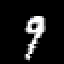

In [ ]:
Image.fromarray(palette9[pixels].reshape(32,32,3), 'RGB').resize((64, 64), Image.NEAREST).show()

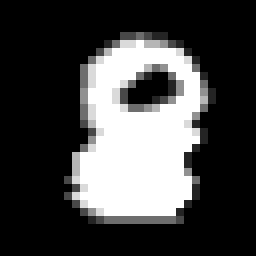

In [ ]:
Image.fromarray(palette9[pixels].reshape(32,32,3), 'RGB').resize((256, 256), Image.NEAREST).show()

## FULL IMAGE GENERATION

In [ ]:
digit_first_row = [219, 365, 292, 146]

In [ ]:
m9.eval()
embeddings = m9.get_input_embeddings()
positional_embeds = m9.pe

prompt = ['[TextFirst]' , '6' , '[Image]']
pixels = []

inputs = t9(''.join(prompt), return_tensors='pt')
input_ids = inputs['input_ids'].to('cuda')


inputs_embeds = embeddings(input_ids)

for i in tqdm(range(1024)):
  # generat 1 pixel

  [pixel_output] = m9.generate(inputs_embeds=inputs_embeds, max_new_tokens=1)
  pixel_id = int(t9.decode(pixel_output)[4:].strip('][')) # grab pixel id from text, ignore EOS 
  

  if i >= 272 and i < 272 + len(digit_first_row):
    pixel_id = digit_first_row[i - 272]

  pixels.append(pixel_id)

  # append pixel embed
  pixel_token_id = 50265 + pixel_id # embedding lookup
  pixel_embed = embeddings(torch.tensor([[pixel_token_id]], dtype=torch.long, device='cuda'))
  pixel_embed_pos = pixel_embed[..., :] + positional_embeds[i, :] # add positional embeddings
  inputs_embeds = torch.concatenate([inputs_embeds, pixel_embed_pos], dim=1)



  0%|          | 0/1024 [00:00<?, ?it/s]

In [ ]:
len(pixels), sum(pixels)

(1024, 0)

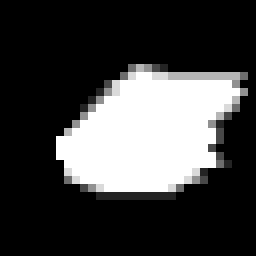

In [ ]:
Image.fromarray(palette9[pixels].reshape(32,32,3), 'RGB').resize((256, 256), Image.NEAREST).show()

In [ ]:
dc = {i : 0 for i in range(10)}

for i in d1['train']['captions']:
  dc[int(i)] += 1

In [ ]:
dc

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

# CIFAR_10

In [ ]:
dcf10 = load_dataset('h4rr9/cifar_10_palette_9_bit')

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
mcf10 = Tim.from_pretrained('h4rr9/cifar_10_9bit_new').to('cuda')
tcf10 = AutoTokenizer.from_pretrained('h4rr9/cifar_10_9bit_new')

In [ ]:
idx = -2
prompt = '[ImageFirst]' + dcf10['validation']['palette_images'][idx] + '[Text]'
caption = dcf10['validation']['captions'][idx]

In [ ]:
inputs = tcf10(prompt, return_tensors='pt')
input_ids = inputs['input_ids'].to('cuda')
attention_mask = inputs['attention_mask'].to('cuda')
image_masks = torch.zeros_like(input_ids, dtype=torch.bool)
image_masks[0, 2:1026] = True

In [ ]:
img_str = tcf10.decode(input_ids[image_masks])
img_str

'[146][219][219][146][146][292][439][366][228][438][365][439][447][447][447][447][447][447][447][447][447][447][447][447][447][447][447][447][301][292][292][438][146][147][146][146][082][219][293][228][155][366][292][374][439][439][439][439][439][439][439][439][439][439][439][447][447][439][447][438][228][154][146][228][146][155][146][147][082][219][219][146][146][228][220][365][366][439][439][439][439][438][438][439][447][447][447][447][439][447][438][292][219][146][081][146][146][146][146][146][082][146][146][146][146][155][220][292][292][438][439][439][439][374][374][439][374][301][374][439][447][447][301][154][146][146][146][146][081][146][146][146][073][146][146][145][082][155][228][219][228][438][439][438][439][301][301][301][219][146][219][292][301][438][292][146][146][146][146][146][073][073][081][146][146][146][081][146][081][219][228][155][219][366][366][366][366][219][219][154][146][146][146][146][146][292][227][146][146][081][145][082][073][073][073][081][146][146][146][146

In [ ]:
len([img_str[chunk_idx: chunk_idx + 5].strip('][') for chunk_idx in range(0, len(img_str), 5)])

1024

In [ ]:
inputs_embeds = mcf10.prepare_inputs(input_ids=input_ids, image_masks=image_masks)

In [ ]:
[output] = mcf10.generate(inputs_embeds=inputs_embeds, attention_mask=attention_mask, max_new_tokens=1)

In [ ]:
tcf10.decode(output, skip_special_tokens=True), caption

('horse', 'automobile')

In [ ]:
from tqdm.auto import tqdm

# create prompt
res = []

image_masks = torch.zeros_like(input_ids, dtype=torch.bool)
image_masks[0, 2:1026] = True

mcf10.eval()

for idx in tqdm(range(10000)):
  prompt = '[ImageFirst]' + dcf10['validation']['palette_images'][idx] + '[Text]'
  caption = dcf10['validation']['captions'][idx]

  # create inputs
  inputs = tcf10(prompt, return_tensors='pt')
  input_ids = inputs['input_ids'].to('cuda')
  attention_mask = inputs['attention_mask'].to('cuda')


  #prepare embeds
  inputs_embeds = mcf10.prepare_inputs(input_ids=input_ids, image_masks=image_masks)
  [output] = mcf10.generate(inputs_embeds=inputs_embeds, attention_mask=attention_mask, max_new_tokens=1)
  o = tcf10.decode(output, skip_special_tokens=True)

  if caption.startswith(o):
    res.append(1)
  else:
    res.append(0)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
print(sum(res) / len(res))

0.6056


In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
res_per_class = {i:0 for i in classes}
count_per_class = {i:0 for i in classes}

captions = dcf10['validation']['captions']
for (r, c) in tqdm(zip(res, captions)):
  res_per_class[c] += r
  count_per_class[c] += 1

res_per_class_acc = {k : res_per_class[k] / count_per_class[k] for k in res_per_class.keys()}

0it [00:00, ?it/s]

In [ ]:
res_per_class_acc

{'airplane': 0.638,
 'automobile': 0.759,
 'bird': 0.422,
 'cat': 0.409,
 'deer': 0.52,
 'dog': 0.549,
 'frog': 0.662,
 'horse': 0.718,
 'ship': 0.737,
 'truck': 0.642}

## HALF IMAGE GENERATION

In [ ]:
import numpy as np
from PIL import Image

palette9 = np.load('./ttim/assets/9-bit.npy')

In [ ]:
idx = 3

half_img = dcf10['validation']['palette_images'][idx]
caption = dcf10['validation']['captions'][idx]
img_str = [half_img[chunk_idx: chunk_idx + 5].strip('][') for chunk_idx in range(0, len(half_img), 5)]
image_idx_np = np.array([int(p) for p in img_str])

half_img_len = len(half_img)//2
half_img = half_img[:half_img_len]
half_img = [half_img[chunk_idx: chunk_idx + 5] for chunk_idx in range(0, len(half_img), 5)]
half_pixel_tokens = [int(p.strip('][')) for p in half_img]
image_numpy = np.array([int(p.strip('][')) for p in half_img])
caption

'airplane'

In [ ]:
class_len = dict()
for c in ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']:
  class_len[c] = len(tcf10.tokenize(c))

In [ ]:
class_len

{'airplane': 2,
 'automobile': 3,
 'bird': 1,
 'cat': 1,
 'deer': 2,
 'dog': 1,
 'frog': 1,
 'horse': 1,
 'ship': 1,
 'truck': 2}

In [ ]:
mcf10.eval()

prompt = ['[TextFirst]' , caption , '[Image]'] + half_img
pixels = half_pixel_tokens.copy()

inputs = tcf10(''.join(prompt), return_tensors='pt')
input_ids = inputs['input_ids'].to('cuda')

embeddings = mcf10.get_input_embeddings()

inputs_embeds = embeddings(input_ids)

positional_embeds = mcf10.pe


for i in range(512):
  inputs_embeds[:, i + 3 + class_len[caption], :] += positional_embeds[i, :]

for i in tqdm(range(512, 1024)):
  # generate 1 pixel

  [pixel_output] = mcf10.generate(inputs_embeds=inputs_embeds, max_new_tokens=1)
  pixel_id = int(tcf10.decode(pixel_output)[4:].strip('][')) # grab pixel id from text, ignore EOS token
  pixels.append(pixel_id)

  # append pixel embed
  pixel_token_id = 50265 + pixel_id # embedding lookup
  pixel_embed = embeddings(torch.tensor([[pixel_token_id]], dtype=torch.long, device='cuda'))
  pixel_embed_pos = pixel_embed[..., :] + positional_embeds[i, :] # add positional embeddings
  inputs_embeds = torch.concatenate([inputs_embeds, pixel_embed_pos], dim=1)



  0%|          | 0/512 [00:00<?, ?it/s]

In [ ]:
len(pixels), sum(pixels)

(1024, 35843)

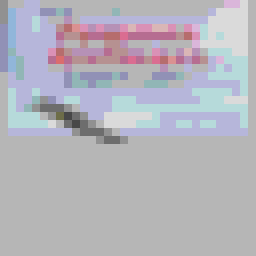

In [ ]:
Image.fromarray(palette9[pixels].reshape(32,32,3), 'RGB').resize((256, 256), Image.NEAREST).show()

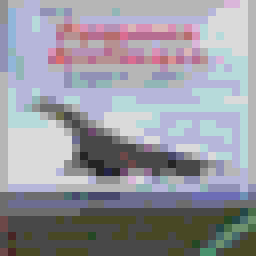

In [ ]:
Image.fromarray(palette9[image_idx_np].reshape(32,32,3), 'RGB').resize((256, 256), Image.NEAREST).show()

In [ ]:
image_idx_np[0], pixels[0],  half_pixel_tokens[0]

(25, 281, 281)

## FULL IMAGE GENERATION

In [ ]:
mcf10.eval()
embeddings = mcf10.get_input_embeddings()
positional_embeds = mcf10.pe

prompt = ['[TextFirst]' , 'airplane' , '[Image]']
pixels = []

inputs = tcf10(''.join(prompt), return_tensors='pt')
input_ids = inputs['input_ids'].to('cuda')


inputs_embeds = embeddings(input_ids)

for i in tqdm(range(1024)):
  # generat 1 pixel

  [pixel_output] = mcf10.generate(inputs_embeds=inputs_embeds, max_new_tokens=1)
  pixel_id = int(tcf10.decode(pixel_output)[4:].strip('][')) # grab pixel id from text, ignore EOS 

  pixels.append(pixel_id)

  # append pixel embed
  pixel_token_id = 50265 + pixel_id # embedding lookup
  pixel_embed = embeddings(torch.tensor([[pixel_token_id]], dtype=torch.long, device='cuda'))
  pixel_embed_pos = pixel_embed[..., :] + positional_embeds[i, :] # add positional embeddings
  inputs_embeds = torch.concatenate([inputs_embeds, pixel_embed_pos], dim=1)



  0%|          | 0/1024 [00:00<?, ?it/s]

In [ ]:
len(pixels), sum(pixels)

(1024, 523264)

In [ ]:
import numpy as np
from PIL import Image

palette9 = np.load('./ttim/assets/9-bit.npy')

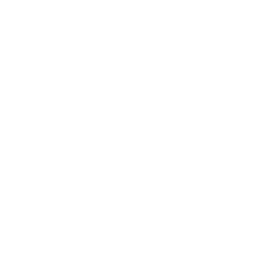

In [ ]:
Image.fromarray(palette9[pixels].reshape(32,32,3), 'RGB').resize((256, 256), Image.NEAREST).show()

In [ ]:
dc = {i : 0 for i in range(10)}

for i in d1['train']['captions']:
  dc[int(i)] += 1

In [ ]:
dc

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}